# Power predictor

### First run generate_TI_set.py, which will generate the simulated TI dataset. 

In [57]:
from data_filter import get_filtered_data, prepare_turbine_seperated_data
from util import get_dataframes, timestamp_to_datetime_index, ws2ti_0
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb



### Getting filtered datasets with Simulated TI

In [58]:
data = get_filtered_data(include_ti=True)
raw_data = prepare_turbine_seperated_data()

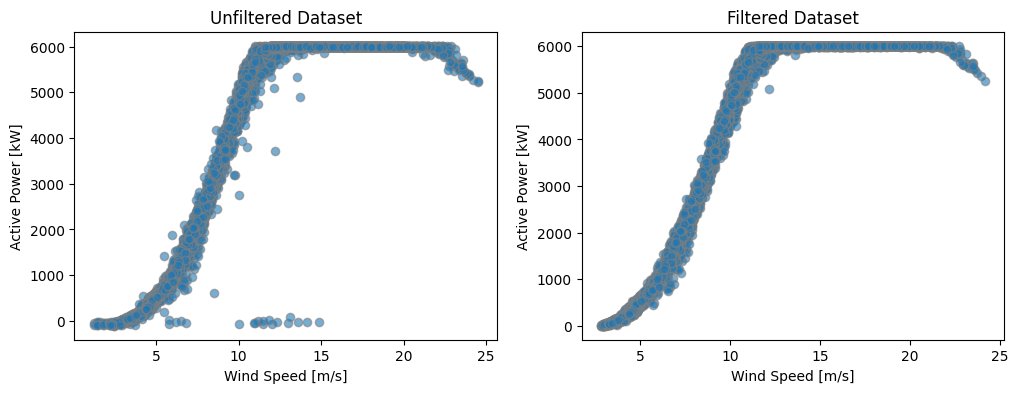

In [59]:
plt.rcParams["figure.figsize"] = (12,4)
tt = 'J04'
fig, axes = plt.subplots(1, 2)
axes[0].scatter(raw_data[tt]['WindSpeed'], raw_data[tt]['ActivePower'], edgecolor = 'gray', alpha = 0.6)
axes[1].scatter(data[tt]['WindSpeed'], data[tt]['ActivePower'], edgecolor = 'gray', alpha = 0.6)
axes[0].set_title('Unfiltered Dataset')
axes[1].set_title('Filtered Dataset')
axes[0].set_xlabel('Wind Speed [m/s]')
axes[1].set_ylabel('Active Power [kW]')
axes[1].set_xlabel('Wind Speed [m/s]')
axes[0].set_ylabel('Active Power [kW]')
plt.show()

In [60]:
print(data.keys())
print(data['A01'].columns)
print(type(data['A01']))
print(len(data['A01']))


dict_keys(['A01', 'A02', 'A03', 'A04', 'A05', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'J01', 'J02', 'J03', 'J04', 'J05', 'K01', 'K02', 'K03', 'K04', 'K05', 'L01', 'L02', 'L03', 'L04', 'L05', 'T01', 'T02', 'T03', 'T04', 'T05'])
Index(['ActivePower', 'Pitch', 'GenRPM', 'WindSpeed', 'WindDirection',
       'YawAngle', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'TSR',
       'YawOffset'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
10128


In [61]:
testdata = get_dataframes(print_names=False)
testdata['simulated_ti'].shape

(11431, 68)

### Pearson correlation.

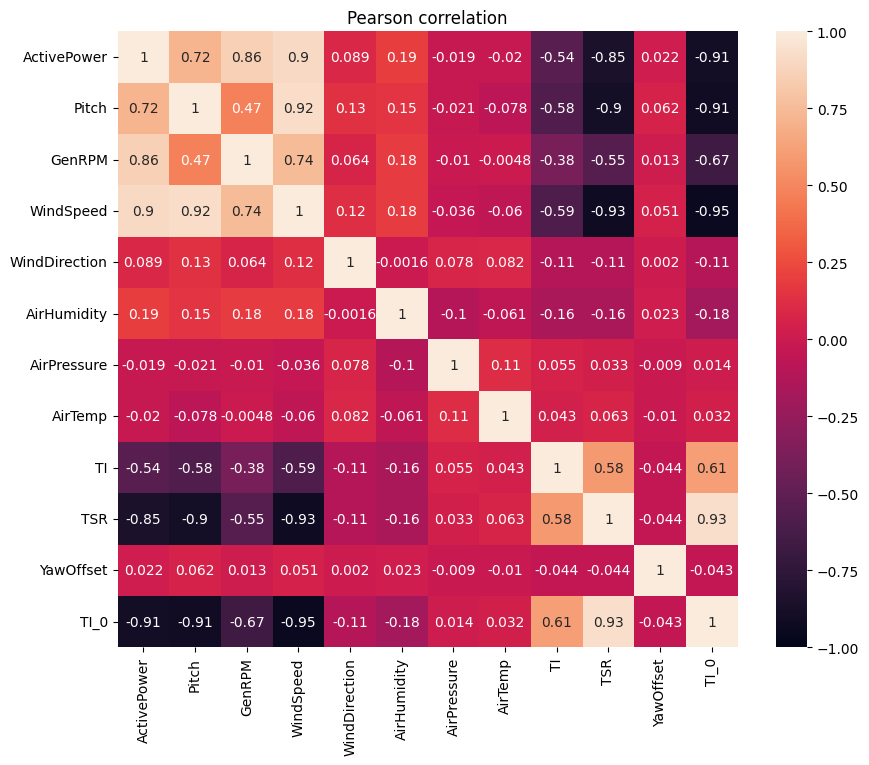

<Figure size 1500x600 with 0 Axes>

In [77]:
plt.rcParams["figure.figsize"] = (10, 8)
corrolation_sample = data['B01'][['ActivePower', 'Pitch', 'GenRPM', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'TSR', 'YawOffset']].sample(frac=0.1)
corrolation_sample['TI_0'] = ws2ti_0(corrolation_sample['WindSpeed'])
corrolation_matrix = corrolation_sample.corr(method="pearson", numeric_only = True)

ax = sb.heatmap(corrolation_matrix, vmin = -1, vmax = 1, annot = True)
plt.figure(figsize=(15,6))
ax.set_title('Pearson correlation', )
plt.show()


### XGBoost model training

In [63]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
#Dividing the training/dataset
test_data = {}
train_data = {}
for name, df_i in tqdm(data.items(), total = 67):
    df_i['TI_0'] = ws2ti_0(df_i['WindSpeed'])
    train, test = train_test_split(df_i, test_size=0.2)
    test_data[name] = test
    train_data[name] = train

100%|██████████| 67/67 [00:00<00:00, 546.05it/s]


Generating hybrid regressors

In [64]:
from xgboost import XGBRegressor
from tqdm import tqdm
import time
hybrid_features = ['Pitch', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'YawOffset', 'TSR','TI_0']
label = 'ActivePower'

hybrid_regressors = {}

for name, test_set in tqdm(test_data.items(), desc='Generating Hybrid Power Predictors (HPP)'):
    bst = XGBRegressor()
    bst.fit(test_set[hybrid_features], test_set[label])
    #bst.save_model(f'./regressors/hybrid/{name}_HPP.json')
    hybrid_regressors[name] = bst


Generating Hybrid Power Predictors (HPP): 100%|██████████| 67/67 [00:03<00:00, 16.93it/s]


Generating standard regressors

In [65]:
standard_features = ['Pitch', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'YawOffset', 'TSR', 'TI_0'] #Only missing simulated TI
label = 'ActivePower'


standard_regressors = {}

for name, test_set in tqdm(test_data.items(), desc='Generating Standard Power Predictors (SPP)'):
    bst = XGBRegressor()
    bst.fit(test_set[standard_features], test_set[label])
    #bst.save_model(f'./regressors/standard/{name}_SPP.json')
    standard_regressors[name] = bst

Generating Standard Power Predictors (SPP): 100%|██████████| 67/67 [00:03<00:00, 17.76it/s]


Getting results of test set

In [66]:
from swt6 import SWT6
standard_predictions = {}
hybrid_predictions = {}
theoretical_predictions = {}

for name, test_df in test_data.items():
        hres = hybrid_regressors[name].predict(test_df[hybrid_features])
        sres = standard_regressors[name].predict(test_df[standard_features])
        tres = SWT6.power_ct(test_df['WindSpeed'].to_numpy())[0]/1000 # because in W and not kW
        
        standard_predictions[name] = sres
        hybrid_predictions[name] = hres
        theoretical_predictions[name] = tres

In [67]:
from sklearn.metrics import root_mean_squared_error

rmse_standard = {}
rmse_hybrid = {}
rmse_theoretical = {}

for name, test_df in test_data.items():
    if name in ['A03', 'A05', 'F01', 'K01', 'L03', 'T03']:
        continue
    rmse_hybrid[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=hybrid_predictions[name])
    rmse_standard[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=standard_predictions[name])
    rmse_theoretical[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=theoretical_predictions[name])

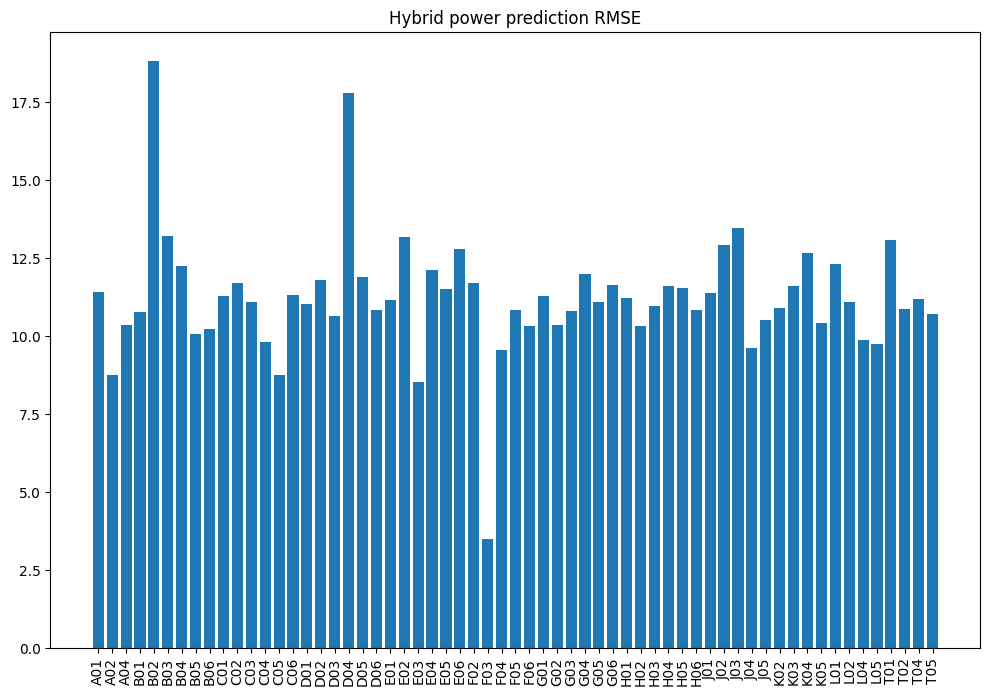

In [68]:
plt.rcParams["figure.figsize"] = (12, 8)

plt.bar(range(len(rmse_hybrid)), list(rmse_hybrid.values()), align='center')
plt.xticks(range(len(rmse_hybrid)), list(rmse_hybrid.keys()))
plt.xticks(rotation=90)
plt.title('Hybrid power prediction RMSE')
plt.show()

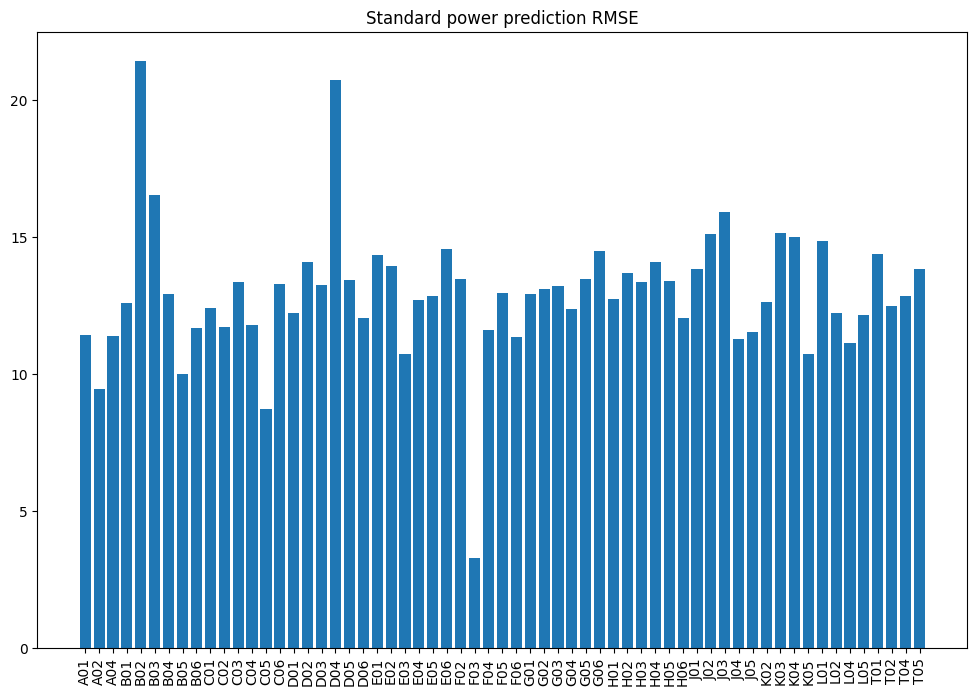

In [69]:
plt.rcParams["figure.figsize"] = (12, 8)

plt.bar(range(len(rmse_standard)), list(rmse_standard.values()), align='center')
plt.xticks(range(len(rmse_standard)), list(rmse_standard.keys()))
plt.xticks(rotation=90)
plt.title('Standard power prediction RMSE')
plt.show()

this plot was aided by chatgpt

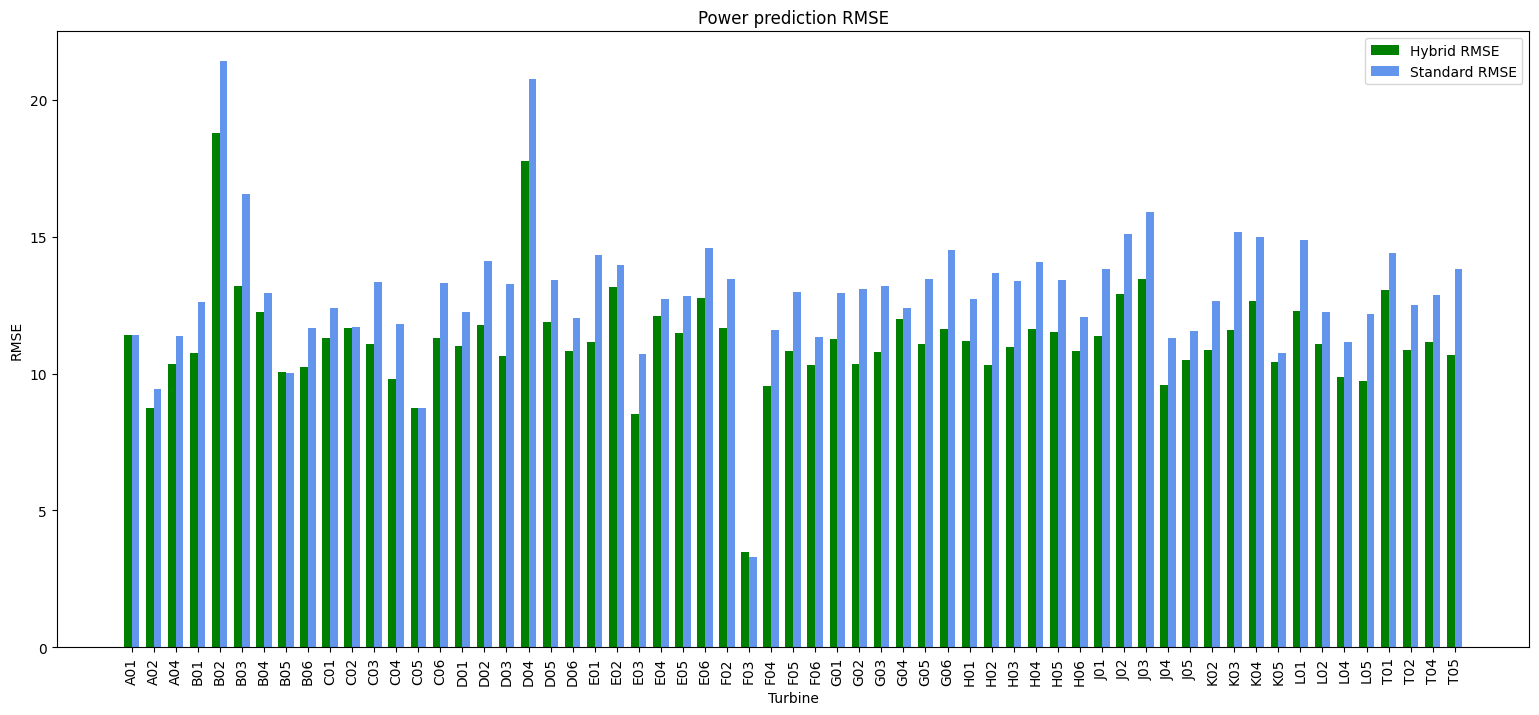

In [70]:
plt.rcParams["figure.figsize"] = (19, 8)

# Extract keys and values
keys = list(rmse_hybrid.keys())
values1 = list(rmse_hybrid.values())
values2 = list(rmse_standard.values())

# Define positions for the bars
bar_width = 0.35
index = np.arange(len(keys))

# Create the bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(index, values1, bar_width, label='Hybrid RMSE', color='green')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='Standard RMSE', color='cornflowerblue')

# Add labels, title, and legend
ax.set_xlabel('Turbine')
ax.set_ylabel('RMSE')
ax.set_title('Power prediction RMSE')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(keys)
plt.xticks(rotation=90)
ax.legend()

# Display the chart
plt.show()

### To exclude:
A03, A05, F01, K01, L03, T03
### These turbine sets are inspected:

In [71]:
from data_filter import prepare_turbine_seperated_data
raw_data = prepare_turbine_seperated_data()


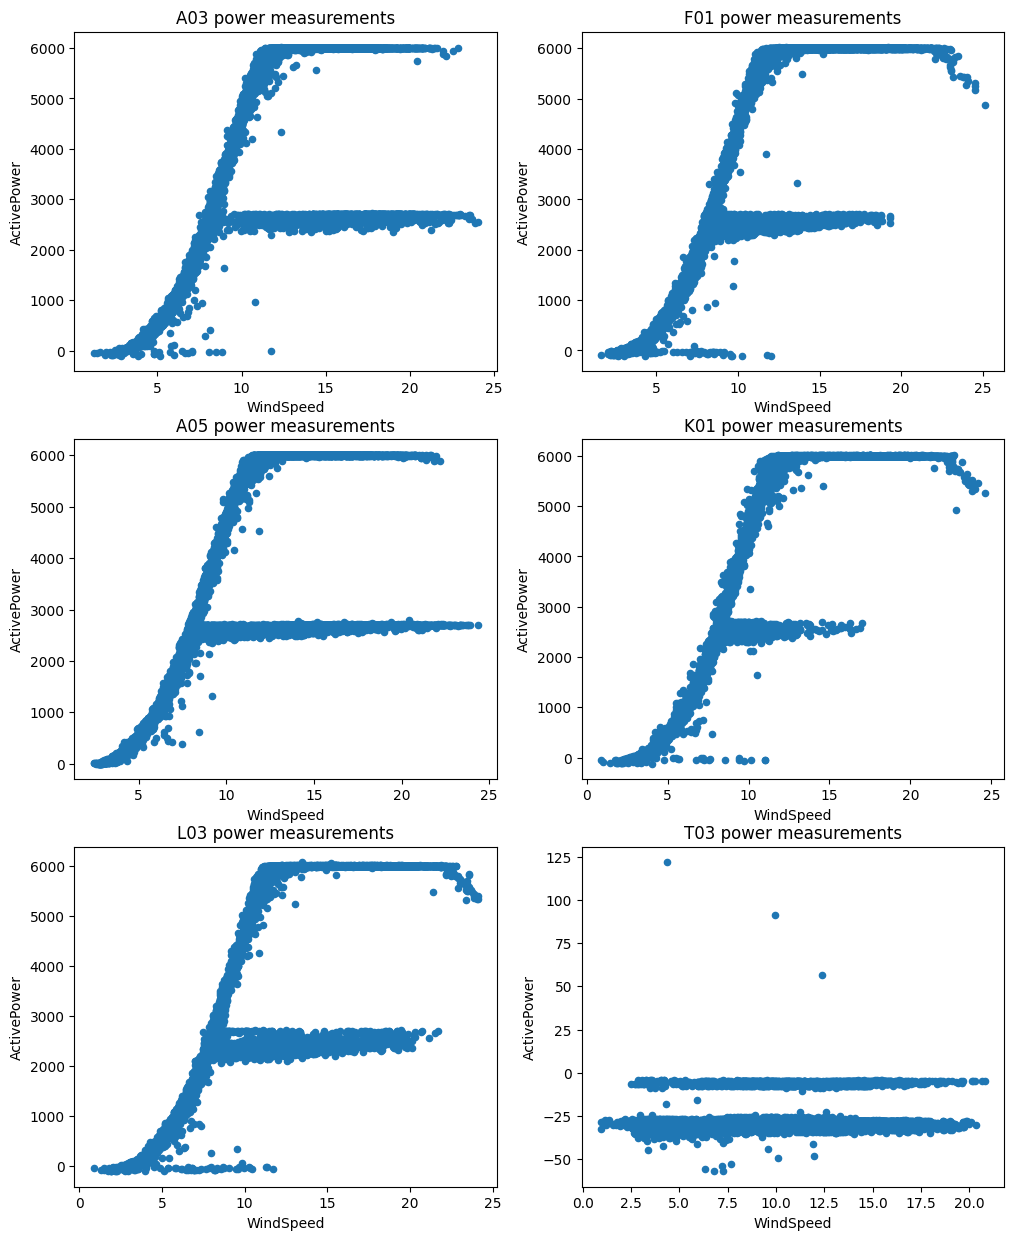

In [72]:
plt.rcParams["figure.figsize"] = (12, 15)

fig, axs = plt.subplots(3, 2)
raw_data['A03'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[0,0])
raw_data['A05'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[1,0])
raw_data['F01'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[0,1])
raw_data['K01'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[1,1])
raw_data['L03'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[2,0])
raw_data['T03'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[2,1])



axs[0,0].set_title('A03 power measurements')
axs[1,0].set_title('A05 power measurements')
axs[0,1].set_title('F01 power measurements')
axs[1,1].set_title('K01 power measurements')
axs[2,0].set_title('L03 power measurements')
axs[2,1].set_title('T03 power measurements')

plt.show()

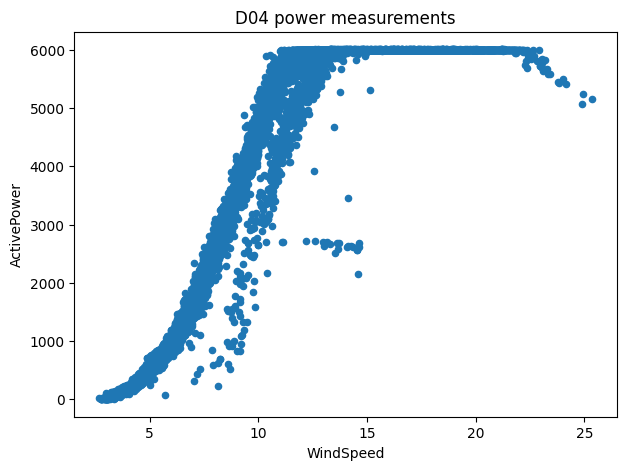

In [73]:
import pandas as pd
plt.rcParams["figure.figsize"] = (7, 5)
data['D04'].plot.scatter(x='WindSpeed', y='ActivePower')
plt.title('D04 power measurements')
plt.show()


### Plotting average RMSE

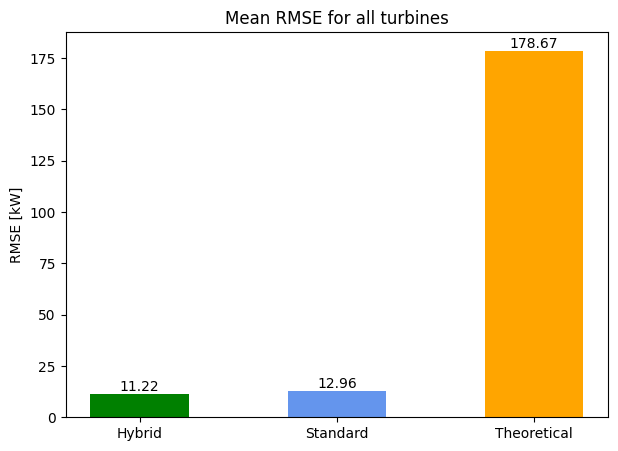

In [74]:
theo_rmse_mean = pd.DataFrame(rmse_theoretical, index=[0]).mean(axis=1)[0]
hybrid_rmse_mean = pd.DataFrame(rmse_hybrid, index=[0]).mean(axis=1)[0]
standard_rmse_mean = pd.DataFrame(rmse_standard, index=[0]).mean(axis=1)[0]

labels = ['Hybrid', 'Standard', 'Theoretical']
values = [hybrid_rmse_mean, standard_rmse_mean, theo_rmse_mean]
colors = ['green', 'cornflowerblue', 'orange']

bars = plt.bar(labels, values, width=0.5, color=colors)

plt.title('Mean RMSE for all turbines')

plt.ylabel('RMSE [kW]')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', 
             fontsize=10, color='black', ha='center') 



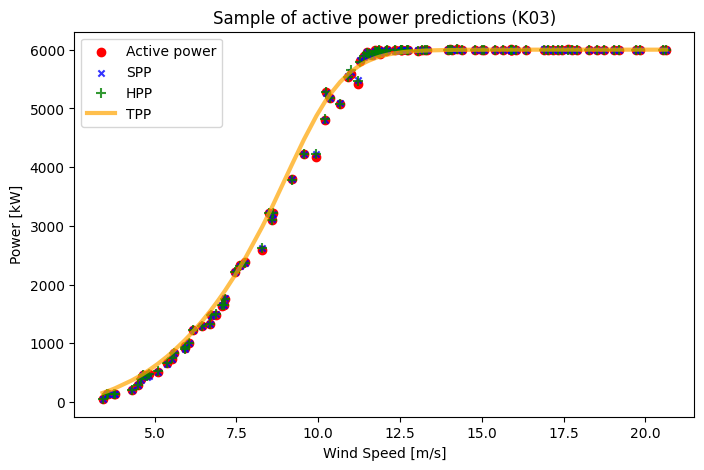

In [76]:
plt.rcParams["figure.figsize"] = (8, 5)
tt = 'K03'
topn = 100
ws = test_data[tt]['WindSpeed'].head(topn)
labels = test_data[tt][label].head(topn)
plt.scatter(ws, labels, color = 'red', label='Active power')
plt.scatter(ws, standard_predictions[tt][:topn], marker='x', color = 'blue', alpha=0.8,s=20, label= 'SPP')
plt.scatter(ws, hybrid_predictions[tt][:topn], marker='+', s=60, color='green', alpha=0.8, label= 'HPP')
plt.plot(ws.sort_values(), SWT6.power_ct(ws.sort_values())[0]/1000, linewidth=3, color='orange', alpha=0.7, label= 'TPP')

plt.legend()
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Power [kW]')
plt.title(f'Sample of active power predictions ({tt})')
plt.show()